In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

# Windows-specific fix for asyncio event loop (required for MCP)
import sys
import asyncio
if sys.platform.startswith("win"):
    asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())


%load_ext autoreload
%autoreload 2

# Multi-Agent Research System

This notebook combines all the previous components into a single system.

Here is our overall research flow:

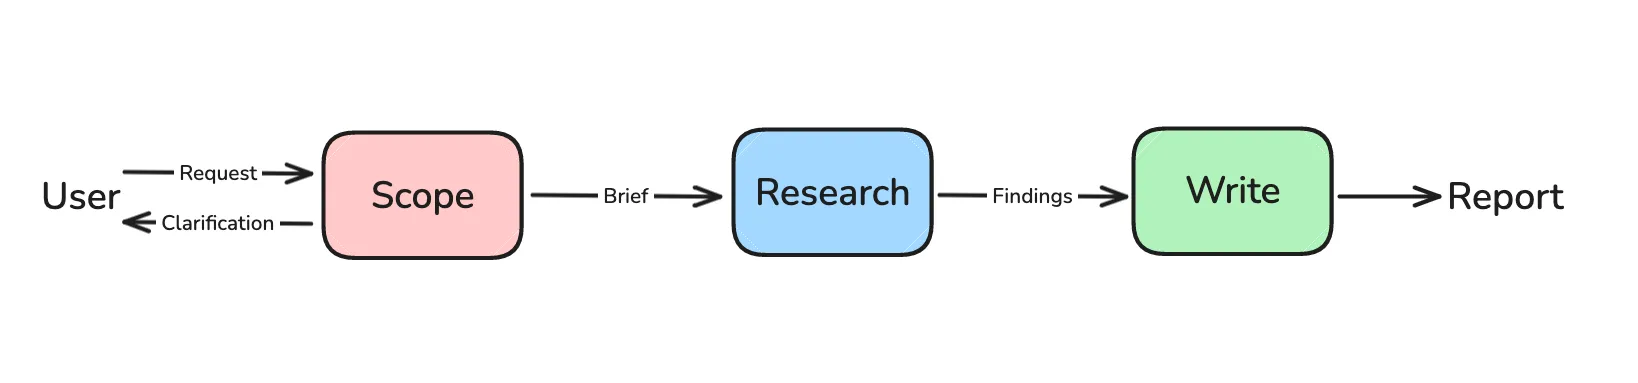

We've built research scoping and multi-agent research in previous notebooks.

Now, we'll add the final report generation step.

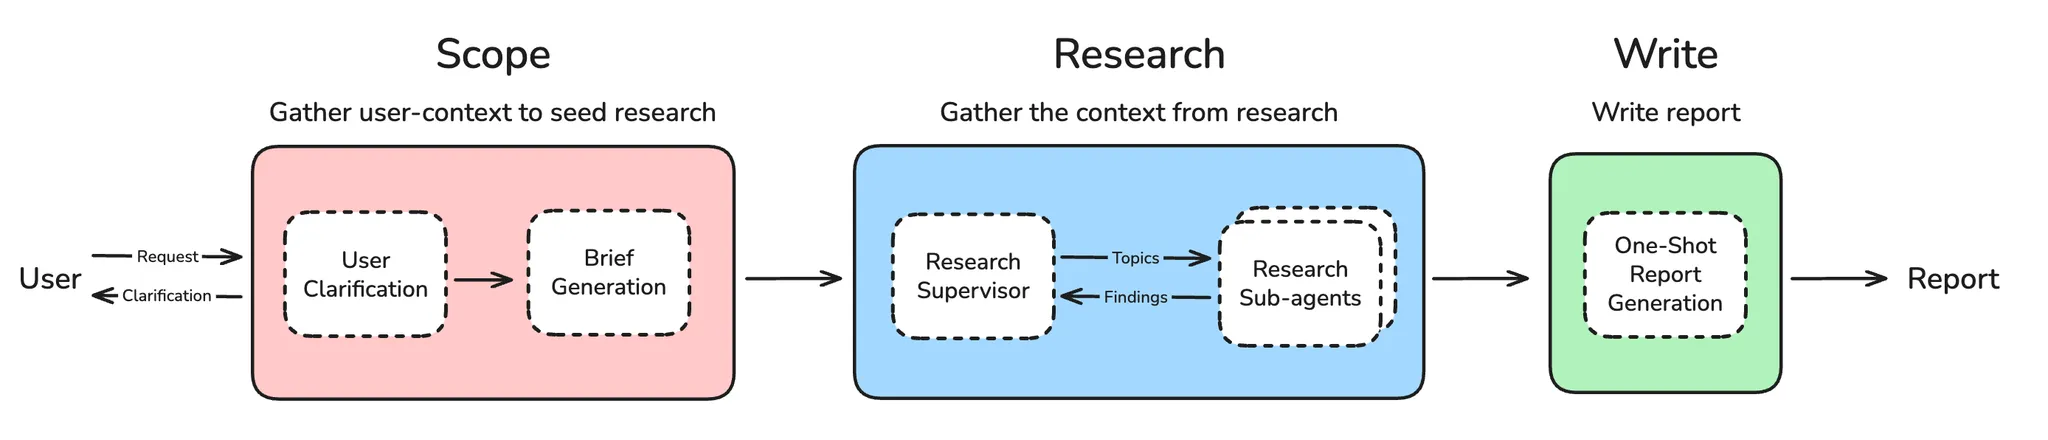

### Agent 

We simply can re-use the components we've already built.

In [2]:
%%writefile ../src/deep_research_from_scratch/research_agent_full.py

"""
Full Multi-Agent Research System

This module integrates all components of the research system:
- User clarification and scoping
- Research brief generation  
- Multi-agent research coordination
- Final report generation

The system orchestrates the complete research workflow from initial user
input through final report delivery.
"""

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

from deep_research_from_scratch.utils import get_today_str
from deep_research_from_scratch.prompts import final_report_generation_prompt
from deep_research_from_scratch.state_scope import AgentState, AgentInputState
from deep_research_from_scratch.research_agent_scope import clarify_with_user, write_research_brief
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

# ===== Config =====

from langchain.chat_models import init_chat_model
writer_model = init_chat_model("groq:llama-3.3-70b-versatile") # model="anthropic:claude-sonnet-4-20250514", max_tokens=64000

# ===== FINAL REPORT GENERATION =====

from deep_research_from_scratch.state_scope import AgentState

async def final_report_generation(state: AgentState):
    """
    Final report generation node.
    
    Synthesizes all research findings into a comprehensive final report
    """
    
    notes = state.get("notes", [])
    
    findings = "\n".join(notes)

    final_report_prompt = final_report_generation_prompt.format(
        research_brief=state.get("research_brief", ""),
        findings=findings,
        date=get_today_str()
    )
    
    final_report = await writer_model.ainvoke([HumanMessage(content=final_report_prompt)])
    
    return {
        "final_report": final_report.content, 
        "messages": ["Here is the final report: " + final_report.content],
    }

# ===== GRAPH CONSTRUCTION =====
# Build the overall workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_node("supervisor_subgraph", supervisor_agent)
deep_researcher_builder.add_node("final_report_generation", final_report_generation)

# Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", "supervisor_subgraph")
deep_researcher_builder.add_edge("supervisor_subgraph", "final_report_generation")
deep_researcher_builder.add_edge("final_report_generation", END)

# Compile the full workflow
agent = deep_researcher_builder.compile()

Overwriting ../src/deep_research_from_scratch/research_agent_full.py


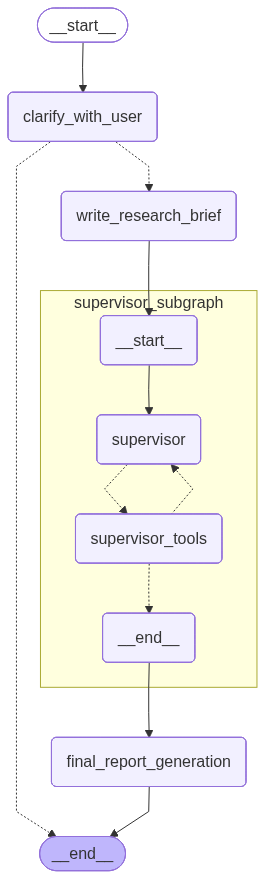

In [3]:
# Run the workflow
from utils import format_messages
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.research_agent_full import deep_researcher_builder

checkpointer = InMemorySaver()
full_agent = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))

LangGraph has a default recursion limit of 25 steps to prevent infinite loops. For complex research workflows that require iterative rounds of research, this limit needs to be increased. As explained in [LangGraph's troubleshooting guide](https://langchain-ai.github.io/langgraph/troubleshooting/errors/GRAPH_RECURSION_LIMIT/), the recursion limit counts every node execution in the graph. In our multi-agent research system:

- **Single Research Agent**: May take 8-12 steps for tool calls and compression
- **Multi-Agent Supervisor**: Each sub-agent spawned adds additional steps
- **Iterative Research**: Supervisor may conduct multiple rounds of research to fill gaps
- **Full Workflow**: Includes scoping, research brief generation, supervision, and report generation

We set the recursion limit to **50** to accommodate:
- Complex research topics requiring multiple research rounds
- Parallel sub-agent execution
- Deep research with many tool calls
- Complete workflow execution from scoping to final report

This allows the supervisor to conduct iterative rounds of research when initial findings have gaps, ensuring comprehensive coverage of complex research topics.

In [4]:
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1", "recursion_limit": 50}}
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Compare Gemini to OpenAI Deep Research agents.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To compare Gemini and OpenAI Deep Research agents, could you please provide more context or specify what        │
│ aspects you would like the comparison to focus on, such as *features*, *performance*, or *use cases*?           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [5]:
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Yes the specific Deep Research products.")]}, config=thread)

In [6]:
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To compare Gemini and OpenAI Deep Research agents, could you please provide more context or specify what        │
│ aspects you would like the comparison to focus on, such as *features*, *performance*, or *use cases*?           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Yes the specific Deep Research products.                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ We have sufficient information to proceed. You would like us to compare Gemini to OpenAI's specific Deep        │
│ Research products, focusing on their features, performance, or use cases. We will now begin the research        │
│ process to provide a comprehensive comparison.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Here is the final report: # Introduction to Gemini and OpenAI's Deep Research Products                          │
│ Gemini and OpenAI are two prominent players in the field of artificial intelligence, offering a range of        │
│ products and services that cater to various needs and applications. This report aims to provide a comprehensive │
│ comparison of Gemini and OpenAI's Deep Research products, focusing on their features, performance, and use      │
│ cases. The comparison will be based on official sources, including the official websites of Gemini and OpenAI,  │
│ as well as reputable technology review websites.                                                                │
│                                                                                                                 │
│ ## Overview of Gemini                                                                                           │
│ Gemini is a conversational AI platform developed by Google. It is designed to process and generate human-like   │
│ text based on the input it receives. Gemini's capabilities include answering questions, providing information,  │
│ and engaging in conversation. According to the official Gemini website [1], Gemini is capable of understanding  │
│ and responding to a wide range of topics and questions, making it a versatile tool for various applications.    │
│                                                                                                                 │
│ ## Overview of OpenAI's Deep Research Products                                                                  │
│ OpenAI is a research organization that focuses on developing and applying artificial intelligence to benefit    │
│ humanity. OpenAI's Deep Research products include a range of models and tools designed for specific tasks and   │
│ applications. For example, OpenAI's language model, described on the OpenAI website [2], is capable of          │
│ generating human-like text based on the input it receives. OpenAI's Deep Research products are designed to push │
│ the boundaries of what is possible with artificial intelligence, and they have been used in various             │
│ applications, including natural language processing and computer vision.                                        │
│                                                                                                                 │
│ ## Comparison of Gemini and OpenAI's Deep Research Products                                                     │
│ When comparing Gemini and OpenAI's Deep Research products, several key differences and similarities emerge.     │
│ Both Gemini and OpenAI's language models are capable of generating human-like text, but they differ in their    │
│ approach and capabilities. Gemini is designed to be a more general-purpose conversational AI platform, while    │
│ OpenAI's language model is designed for more specific tasks and applications. According to a review by          │
│ TechCrunch [3], OpenAI's language model is more advanced and capable of generating more coherent and            │
│ context-specific text.                                                                                          │
│                                                                                                                 │
│ In terms of performance, both Gemini and OpenAI's Deep Research products have demonstrated impressive           │
│ capabilities. However, OpenAI's language model has been shown to outperform Gemini in certain tasks, such as    │
│ text generation and conversation. According to a study published on the arXiv website [4], OpenAI's language    │
│ model was able to generate more coherent and engaging text than Gemini.                                         │
│                                                        

In [7]:
from rich.markdown import Markdown
Markdown(result["final_report"])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                           Introduction to Gemini and OpenAI's Deep Research Products                            ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

Gemini and OpenAI are two prominent players in the field of artificial intelligence, offering a range of products  
and services that cater to various needs and applications. This report aims to provide a comprehensive comparison  
of Gemini and OpenAI's Deep Research products, focusing on their features, performance, and use cases. The         
comparison will be based on official sources, including the official websites of Gemini and OpenAI, as well as     
reputable technology review websites.                                                                              


                                                Overview of Gemini                                                 

Gemini is a conversational AI platform developed by Google. It is designed to process and generate human-like text 
based on the input it receives. Gemini's capabilities include answering questions, providing information, and      
engaging in conversation. According to the official Gemini website [1], Gemini is capable of understanding and     
responding to a wide range of topics and questions, making it a versatile tool for various applications.           


                                    Overview of OpenAI's Deep Research Products                                    

OpenAI is a research organization that focuses on developing and applying artificial intelligence to benefit       
humanity. OpenAI's Deep Research products include a range of models and tools designed for specific tasks and      
applications. For example, OpenAI's language model, described on the OpenAI website [2], is capable of generating  
human-like text based on the input it receives. OpenAI's Deep Research products are designed to push the boundaries
of what is possible with artificial intelligence, and they have been used in various applications, including       
natural language processing and computer vision.                                                                   


                             Comparison of Gemini and OpenAI's Deep Research Products                              

When comparing Gemini and OpenAI's Deep Research products, several key differences and similarities emerge. Both   
Gemini and OpenAI's language models are capable of generating human-like text, but they differ in their approach   
and capabilities. Gemini is designed to be a more general-purpose conversational AI platform, while OpenAI's       
language model is designed for more specific tasks and applications. According to a review by TechCrunch [3],      
OpenAI's language model is more advanced and capable of generating more coherent and context-specific text.        

In terms of performance, both Gemini and OpenAI's Deep Research products have demonstrated impressive capabilities.
However, OpenAI's language model has been shown to outperform Gemini in certain tasks, such as text generation and 
conversation. According to a study published on the arXiv website [4], OpenAI's language model was able to generate
more coherent and engaging text than Gemini.                                                                       


                                            Use Cases and Applications                                             

Gemini and OpenAI's Deep Research products have a wide range of potential use cases and applications. Gemini can be
used in customer service, tech support, and other applications where conversational AI is beneficial. OpenAI's Deep
Research products can be used in more specific applications, such as natural language processing, computer vision, 
and robotics. According to an article by W

We can see the trace [here](https://smith.langchain.com/public/86ebdc25-4595-4040-be1e-a8e30052786b/r).

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

The files we wrote with `%%writefile` to `src/deep_research_from_scratch/` during the all the notebooks create the files for our application:

```
deep_research_from_scratch/
├── src/deep_research_from_scratch/
│   ├── state.py          # State definitions
│   ├── scope_research.py # Scoping workflow
│   ├── prompts.py        # Prompt templates
│   └── ...
├── notebooks/            # Development notebooks
├── pyproject.toml        # Dependencies
└── langgraph.json        # LangGraph configuration
```

This agent has been added to the `langgraph.json` file, so you can select `research_agent_full` in the dropdown menu:

```
"research_agent_full": "./src/deep_research_from_scratch/research_agent_full.py:agent"
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```